# Введение в искусственные нейронные сети
# Урок 6. Сегментация
## Практическое задание   


Вариант 1
<ol>
<li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете.  
<li>Опишите, какой результата вы получили? Что помогло вам улучшить качество сети?  
</ol>

Вариант 2  
*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview<br>   
Вариант 3   
*Сделайте свою реализацию U-Net на TensorFlow  

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import os

import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Tensorflow with TPU

In [4]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

### Tensorflow with GPU

In [5]:
# %tensorflow_version 2.x
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#     raise SystemError('GPU device not found')

# def cpu():
#     with tf.device('/cpu:0'):
#         random_image_cpu = tf.random.normal((100, 100, 100, 3))
#         net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#         return tf.math.reduce_sum(net_cpu)

# def gpu():
#     with tf.device('/device:GPU:0'):
#         random_image_gpu = tf.random.normal((100, 100, 100, 3))
#         net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#         return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

### Загрузка данных

In [6]:
train_df_origin = pd.read_csv('./severstal-steel-defect-detection/train.csv')
train_df_origin.shape

(7095, 3)

In [7]:
TRAIN_PATH = './severstal-steel-defect-detection/train_images/'
from glob import glob
train_fns = pd.Series(sorted(glob(TRAIN_PATH + '*.jpg')))
train_fns_split = train_fns.str.split('/', expand=True)

### Изучение датасета

In [8]:
train_df_origin.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 822...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 29670...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 38863 28 39119 28 39375 29 39631 29 39887 29 40143 29 40399 29 40655 30 40911 30 41167 30 41423 30 41679 31 41935 31 42191 31 42447 31 42703 31 42960 31 43216 31 43472 31 43728 31 43984 31 44240 32 44496 32 44752 32 45008 32 45264 33 45520 33 45776 33 4...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 133248 13 133503 16 133757 19 134012 22 134267 24 134522 26 134777 29 135032 31 135287 34 135542 36 135796 40 136050 43 136304 46 136558 50 136812 54 137066 56 137320 59 137574 61 137828 63 138082 65 138336 68 138590 70 138845 71 139101 71 139356 73 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468 92 230623 10 230724 95 230845 11 230869 28 230979 97 231094 63 231235 97 231344 70 231490 99 231593 79 231746 183 232002 184 232257 186 232513 186 232769 185 233024 186 233280 185 233535 186 233791 185 234047 185 234302 186 234558 186 234813 186 235...


In [9]:
train_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
for i in tqdm(range(len(train_df_origin))):
    for j in range(4):
        tmp_se = pd.Series([train_df_origin['ImageId'][i]+'_{}'.format(j+1),None], index=train_df.columns)
        train_df = train_df.append(tmp_se, ignore_index=True )
train_df.head()

# sub_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
# for i in tqdm(range(len(sub_df_origin))):
#     for j in range(4):
#         tmp_se = pd.Series( [sub_df_origin['ImageId'][i]+'_{}'.format(j+1),None], index=sub_df.columns )
#         sub_df = sub_df.append( tmp_se, ignore_index=True )
# sub_df.head(9)

100%|██████████| 7095/7095 [01:20<00:00, 88.61it/s]


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,None
1,0002cc93b.jpg_2,None
2,0002cc93b.jpg_3,None
3,0002cc93b.jpg_4,None
4,0007a71bf.jpg_1,None


In [10]:
for i in tqdm(range(len(train_df_origin))):
    imageid_classid = train_df_origin['ImageId'][i]+'_{}'.format(train_df_origin['ClassId'][i])
    idx=train_df.query('ImageId_ClassId == "{}"'.format(imageid_classid)).index[0]
    train_df['EncodedPixels'][idx] = train_df_origin['EncodedPixels'][i]
train_df.head()

100%|██████████| 7095/7095 [00:27<00:00, 261.82it/s]


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 822...
1,0002cc93b.jpg_2,None
2,0002cc93b.jpg_3,None
3,0002cc93b.jpg_4,None
4,0007a71bf.jpg_1,None


In [14]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(28380, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 822...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,None,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,None,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,None,0002cc93b.jpg,4,False
4,0007a71bf.jpg_1,None,0007a71bf.jpg,1,False


In [15]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(6666, 2)


,ImageId,hasMask
6253,ef24da2ba.jpg,3
5740,db4867ee8.jpg,3
3435,84865746c.jpg,2
2203,5665ada1b.jpg,2
6149,eb44ad79d.jpg,2


### Построение модели

In [16]:
sub_df_origin = pd.read_csv('./severstal-steel-defect-detection/sample_submission.csv')
sub_df_origin.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [17]:
sub_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
for i in tqdm(range(len(sub_df_origin))):
    for j in range(4):
        tmp_se = pd.Series( [sub_df_origin['ImageId'][i]+'_{}'.format(j+1),None], index=sub_df.columns )
        sub_df = sub_df.append( tmp_se, ignore_index=True )
sub_df.head(9)

100%|██████████| 5506/5506 [01:03<00:00, 86.43it/s]


,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,None
1,0000f269f.jpg_2,None
2,0000f269f.jpg_3,None
3,0000f269f.jpg_4,None
4,000ccc2ac.jpg_1,None
5,000ccc2ac.jpg_2,None
6,000ccc2ac.jpg_3,None
7,000ccc2ac.jpg_4,None
8,002451917.jpg_1,None


In [22]:
sub = pd.read_csv('./severstal-steel-defect-detection/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

### Mask encoding and decoding

In [23]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [24]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

### Loss function

In [25]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Sample Test

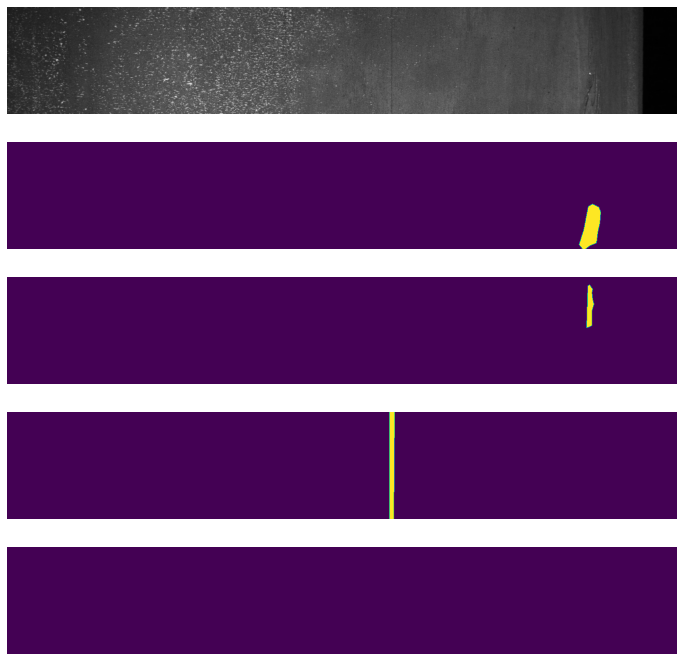

In [27]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"./severstal-steel-defect-detection/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

### Data Generator

In [30]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [31]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

### Model

In [32]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

### Training

In [33]:
model = build_model((256, 1600, 1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 800, 8)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Evaluation & Submission

In [36]:
# model.load_weights('./modelunet3/model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='./severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

Instructions for updating:
Please use Model.predict, which supports generators.
500/500 [==============================] - 158s 315ms/step


500it [05:25,  1.54it/s]


500/500 [==============================] - 156s 312ms/step


MemoryError: Unable to allocate 3.05 GiB for an array with shape (500, 256, 1600, 4) and data type float32

In [ ]:
subb = pd.concat(test_df)

In [ ]:
sub.head()

In [ ]:
sub.to_csv('submission.csv', index=False)